COMP9727 Lixian Deng z5556881

1. In the the tutorial, we use "text = re.sub(r'[^\w\s]', '', text)" to remove all non-word characters and non-whitespace characters. But in sentiment or lyrics, retaining symbols such as ?, ! and don't to dont. that can sometimes help the model better identify tone. After searching, I try to use the NLTK's tokenizer to do it. And I add a cross-validation using cross_val_score.

In [1]:
!pip install nltk

In [25]:

import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as pl
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from nltk.tokenize import word_tokenize
from sklearn.svm import LinearSVC

nltk.download('stopwords')
nltk.download('punkt') 
nltk.download('punkt_tab')

# Build the expanded stop word list
default_stopwords = set(stopwords.words('english'))
custom_words = {"yeah", "oh", "na", "la", "uh", "ooh", "woah", "huh", "gonna", "think", "wanna", "feel", "want"}
all_stopwords = default_stopwords.union(custom_words)

# Define text preprocessing functions
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    allowed_punct = {"'", "-"}
    tokens = [
        token for token in tokens 
        if token not in string.punctuation or token in allowed_punct
    ]
    tokens = [word for word in tokens if word not in all_stopwords]  # Remove stopwords
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    return ' '.join(tokens)

# load the data and apply preprocessing
df = pd.read_csv("dataset.tsv", sep='\t')
df = df.dropna()  
df['text'] = df['artist_name'] + ' ' + df['track_name'] + ' ' + df['genre'] + ' ' + df['lyrics']
df['clean_text'] = df['text'].apply(preprocess_text)

# Vectorization using CountVectorizer
vectorizer = CountVectorizer()

# Building MNB pipeline
mnb_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', MultinomialNB())
])

# cross validation
X = df['clean_text']
y = df['topic']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(mnb_pipeline, X, y, cv=cv, scoring='accuracy')
print("MultinomialNB Average accuracy：", np.mean(scores))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\961195909\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\961195909\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\961195909\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


MultinomialNB Average accuracy： 0.8019999999999999


2. I think in the songs we can use NLTK to find the stopword and also I add some words like 'wanna' to expand it, the tokenize can help me to get each 'word'. The lower word and stemming are shown in the code.

In [28]:

# Building BNB pipeline
bnb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('classifier', BernoulliNB())
])

# Define the evaluation metric for cross validation
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro')
}

# Perform cross validation
bnb_acc_scores = cross_val_score(bnb_pipeline, X, y, cv=cv, scoring='accuracy')
mnb_acc_scores = cross_val_score(mnb_pipeline, X, y, cv=cv, scoring='accuracy')

bnb_f1_scores = cross_val_score(bnb_pipeline, X, y, cv=cv, scoring='f1_macro')
mnb_f1_scores = cross_val_score(mnb_pipeline, X, y, cv=cv, scoring='f1_macro')

# output
print("BNB Average accuracy：", np.mean(bnb_acc_scores))
print("BNB Average F1-macro：", np.mean(bnb_f1_scores))
print("MNB Average accuracy：", np.mean(mnb_acc_scores))
print("MNB Average F1-macro：", np.mean(mnb_f1_scores))

BNB Average accuracy： 0.5486666666666666
BNB Average F1-macro： 0.3593727193033674
MNB Average accuracy： 0.8019999999999999
MNB Average F1-macro： 0.7416679978469419


In [30]:
df['topic'].value_counts()

topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64

As you can see, the diff category is imbalance.

3. I use accuracy and F1-macro score as evaluation metrics. The accuracy can measure the proportion of correct classification in the classification, due to the imbalance of our categories, F1-macro score can balance the precisio and recall of each category.
And it shows that MNB is better than BNB.

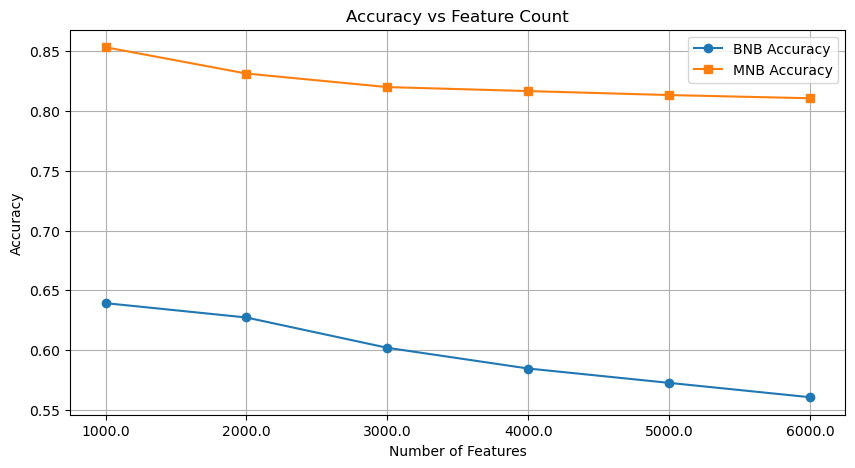

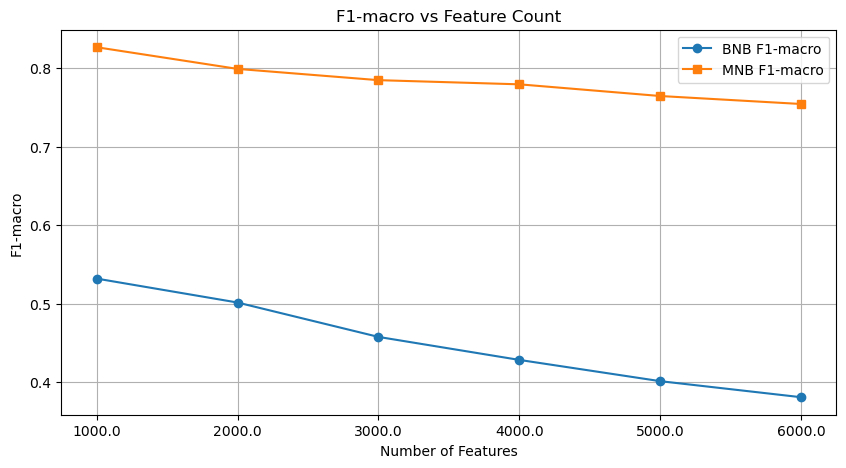

In [34]:

# Define N
feature_nums = [1000, 2000, 3000, 4000, 5000, 6000, None] 

# save results
results = {
    'N': [],
    'BNB_accuracy': [],
    'MNB_accuracy': [],
    'BNB_f1': [],
    'MNB_f1': []
}

for n in feature_nums:
    
    vec = CountVectorizer(max_features=n)
    
    bnb_pipeline = Pipeline([
        ('vectorizer', vec),
        ('classifier', BernoulliNB())
    ])
    
    mnb_pipeline = Pipeline([
        ('vectorizer', vec),
        ('classifier', MultinomialNB())
    ])
    
    bnb_acc = cross_val_score(bnb_pipeline, X, y, cv=cv, scoring='accuracy').mean()
    bnb_f1 = cross_val_score(bnb_pipeline, X, y, cv=cv, scoring='f1_macro').mean()
    mnb_acc = cross_val_score(mnb_pipeline, X, y, cv=cv, scoring='accuracy').mean()
    mnb_f1 = cross_val_score(mnb_pipeline, X, y, cv=cv, scoring='f1_macro').mean()
    
    results['N'].append(n)
    results['BNB_accuracy'].append(bnb_acc)
    results['MNB_accuracy'].append(mnb_acc)
    results['BNB_f1'].append(bnb_f1)
    results['MNB_f1'].append(mnb_f1)

# trans to DataFrame 
result_df = pd.DataFrame(results)

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(result_df['N'], result_df['BNB_accuracy'], marker='o', label='BNB Accuracy')
plt.plot(result_df['N'], result_df['MNB_accuracy'], marker='s', label='MNB Accuracy')
plt.title("Accuracy vs Feature Count")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.xticks(result_df['N'], [str(n) if n is not None else 'all' for n in result_df['N']])
plt.show()

# F1-macro
plt.figure(figsize=(10, 5))
plt.plot(result_df['N'], result_df['BNB_f1'], marker='o', label='BNB F1-macro')
plt.plot(result_df['N'], result_df['MNB_f1'], marker='s', label='MNB F1-macro')
plt.title("F1-macro vs Feature Count")
plt.xlabel("Number of Features")
plt.ylabel("F1-macro")
plt.legend()
plt.grid(True)
plt.xticks(result_df['N'], [str(n) if n is not None else 'all' for n in result_df['N']])
plt.show()


3. I use accuracy and F1-macro score as evaluation metrics. The accuracy can measure the proportion of correct classification in the classification, due to the imbalance of our categories, F1-macro score can balance the precisio and recall of each category.
And it shows that MNB is better than BNB.

In [37]:

# Building SVM pipeline
svm_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=6000)), 
    ('classifier', LinearSVC())
])

# Cross Validation
svm_acc_scores = cross_val_score(svm_pipeline, X, y, cv=cv, scoring='accuracy')
svm_f1_scores = cross_val_score(svm_pipeline, X, y, cv=cv, scoring='f1_macro')

print("SVM Average accuracy：", np.mean(svm_acc_scores))
print("SVM F1-macro Average score：", np.mean(svm_f1_scores))


E:\anocode\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anocode\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anocode\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anocode\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anocode\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anocode\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anocode\Lib\site-packages\sklearn\svm\_base.py:12

SVM Average accuracy： 0.8619999999999999
SVM F1-macro Average score： 0.8355324973473088


E:\anocode\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\anocode\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
# summarize the results
summary = pd.DataFrame({
    'Model': ['BNB', 'MNB', 'SVM'],
    'Accuracy': [np.mean(bnb_acc_scores), np.mean(mnb_acc_scores), np.mean(svm_acc_scores)],
    'F1-macro': [np.mean(bnb_f1_scores), np.mean(mnb_f1_scores), np.mean(svm_f1_scores)]
})

print("comparison results：")
print(summary)


comparison results：
  Model  Accuracy  F1-macro
0   BNB  0.548667  0.359373
1   MNB  0.802000  0.741668
2   SVM  0.862000  0.835532


5. the slides of the lecture gives us few machine learning methods, I select SVM as the third.The basic idea is to separate data of different categories by finding an optimal hyperplane. The goal of SVM is to maximize the classification boundary, that is, to make the distance (i.e., "interval") between the hyperplane and the sample points of each category as large as possible.
   I used it in comp9517, it's good at nonlinear problems and image classification, text classification, and it perform better when the size of sample is small. I think SVM is better than both methods I use the the former code.
   In a dataset like there may be some degree of correlation between features (e.g. certain words appear frequently in the same category), the SVM can mapping data to the higher-dimensional space to effectively handle complex boundaries between categories, MNB can be affected when the correlation between the features of the data is strong and BNB assumes that each feature exists independently in different categories, that maybe limit its performance for text data with strongly correlated features.

In [42]:
# train set（Week 1–3）
train_df = df.iloc[:750].copy()
train_df['clean_text'] = train_df['text'].apply(preprocess_text)

# test set (week4)
test_df = df.iloc[750:1000].copy()
test_df['clean_text'] = test_df['text'].apply(preprocess_text) 

# SVM model training
X_train = train_df['clean_text']
y_train = train_df['topic']


svm_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=6000)),
    ('classifier', LinearSVC())
])
svm_pipeline.fit(X_train, y_train)

# Making predictions on the training data
train_df['predicted_topic'] = svm_pipeline.predict(train_df['clean_text'])
test_df['predicted_topic'] = svm_pipeline.predict(test_df['clean_text'])

In [44]:
# Read user1.tsv file and convert it to topic -> list of keywords dictionary

user1_df = pd.read_csv("user1.tsv", sep='\t', header=0, names=["topic", "keywords"])
user1_keywords = {
    row["topic"]: [kw.strip().lower() for kw in row["keywords"].split(',')]
    for _, row in user1_df.iterrows()
}


# Construct User1's subject profile document
user1_docs = {}
for topic, keywords in user1_keywords.items():
    liked_lyrics = train_df[
        train_df.apply(
            lambda row: row['predicted_topic'] == topic and 
            any(kw in row['clean_text'] for kw in keywords), axis=1
        )
    ]['clean_text']
    user1_docs[topic] = ' '.join(liked_lyrics.tolist())

# Build TF-IDF vector and extract the top 20 high-weight words
vectorizer = TfidfVectorizer(max_features=6000, stop_words=list(all_stopwords))
top_keywords_per_topic = {}

for topic, doc in user1_docs.items():
    tfidf_matrix = vectorizer.fit_transform([doc])
    feature_array = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_indices = tfidf_scores.argsort()[-20:][::-1]
    top_keywords = [(feature_array[i], tfidf_scores[i]) for i in top_indices]
    top_keywords_per_topic[topic] = top_keywords

# output the top 20 high-weight words in each topic
for topic, keywords in top_keywords_per_topic.items():
    print(f"\\nUser1 - Top 20 TF-IDF words for topic '{topic}':")
    for word, score in keywords:
        print(f"{word}: {score:.4f}")


\nUser1 - Top 20 TF-IDF words for topic 'dark':
fight: 0.3536
know: 0.2864
come: 0.2341
like: 0.2291
black: 0.1918
blood: 0.1843
stand: 0.1718
grind: 0.1619
tell: 0.1494
hand: 0.1370
gon: 0.1320
time: 0.1245
kill: 0.1195
head: 0.1170
caus: 0.1121
right: 0.1046
light: 0.1021
heart: 0.0946
good: 0.0872
follow: 0.0872
\nUser1 - Top 20 TF-IDF words for topic 'sadness':
leav: 0.5399
place: 0.3240
greater: 0.2700
regret: 0.2700
hold: 0.2160
caus: 0.2160
chang: 0.1620
mind: 0.1620
away: 0.1620
beg: 0.1620
blame: 0.1620
word: 0.1620
break: 0.1080
dream: 0.1080
lord: 0.1080
space: 0.1080
tell: 0.1080
trust: 0.1080
wider: 0.1080
father: 0.0540
\nUser1 - Top 20 TF-IDF words for topic 'personal':
life: 0.6404
live: 0.3266
know: 0.2221
chang: 0.1665
world: 0.1653
time: 0.1498
like: 0.1459
dream: 0.1343
come: 0.1162
wan: 0.1059
thing: 0.1059
thank: 0.0955
need: 0.0904
go: 0.0852
caus: 0.0852
teach: 0.0813
lord: 0.0800
right: 0.0749
look: 0.0710
believ: 0.0697
\nUser1 - Top 20 TF-IDF words for topic 

In [46]:
# Read user2.tsv file and convert it to topic -> list of keywords dictionary
user2_df = pd.read_csv("user2.tsv", sep='\t', header=0, names=["topic", "keywords"])
user2_keywords = {
    row["topic"]: [kw.strip().lower() for kw in row["keywords"].split(',')]
    for _, row in user2_df.iterrows()
}


# Construct User1's subject profile document
user2_docs = {}
for topic, keywords in user2_keywords.items():
    liked_lyrics = train_df[
        train_df.apply(
            lambda row: row['predicted_topic'] == topic and 
            any(kw in row['clean_text'] for kw in keywords), axis=1
        )
    ]['clean_text']
    user2_docs[topic] = ' '.join(liked_lyrics.tolist())

# Build TF-IDF vector and extract the top 20 high-weight words
vectorizer = TfidfVectorizer(max_features=6000)
top_keywords_per_topic = {}

for topic, doc in user2_docs.items():
    tfidf_matrix = vectorizer.fit_transform([doc])
    feature_array = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_indices = tfidf_scores.argsort()[-20:][::-1]
    top_keywords = [(feature_array[i], tfidf_scores[i]) for i in top_indices]
    top_keywords_per_topic[topic] = top_keywords

# output the top 20 high-weight words in each topic
for topic, keywords in top_keywords_per_topic.items():
    print(f"\\nUser2 - Top 20 TF-IDF words for topic '{topic}':")
    for word, score in keywords:
        print(f"{word}: {score:.4f}")

\nUser2 - Top 20 TF-IDF words for topic 'sadness':
open: 0.3413
smile: 0.2560
away: 0.2560
tear: 0.2560
come: 0.2560
magnifi: 0.2560
eye: 0.1707
tell: 0.1707
life: 0.1707
tri: 0.1422
babi: 0.1422
laughter: 0.1422
lone: 0.1422
road: 0.1138
hold: 0.1138
good: 0.1138
lose: 0.1138
leav: 0.1138
sorrow: 0.1138
promis: 0.0853
\nUser2 - Top 20 TF-IDF words for topic 'emotion':
touch: 0.5794
good: 0.4411
hold: 0.2634
kiss: 0.2173
morn: 0.1909
vision: 0.1712
know: 0.1580
video: 0.1580
loov: 0.1514
time: 0.1448
luck: 0.1317
lovin: 0.1251
sunris: 0.1185
lip: 0.1185
gim: 0.1119
like: 0.0856
go: 0.0856
wait: 0.0790
knock: 0.0724
love: 0.0724


In [48]:
# Read user3  and convert it to topic -> list of keywords dictionary
user3_df = pd.read_csv("user3.tsv", sep='\t', header=0, names=["topic", "keywords"])
user3_keywords = {
    row["topic"]: [kw.strip().lower() for kw in row["keywords"].split(',')]
    for _, row in user3_df.iterrows()
}


user3_docs = {}
for topic, keywords in user3_keywords.items():
    liked_lyrics = train_df[
        train_df.apply(
            lambda row: row['predicted_topic'] == topic and 
            any(kw in row['clean_text'] for kw in keywords), axis=1
        )
    ]['clean_text']
    user3_docs[topic] = ' '.join(liked_lyrics.tolist())

vectorizer = TfidfVectorizer(max_features=6000)
top_keywords_per_topic = {}

for topic, doc in user3_docs.items():
    tfidf_matrix = vectorizer.fit_transform([doc])
    feature_array = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()[0]
    top_indices = tfidf_scores.argsort()[-20:][::-1]
    top_keywords = [(feature_array[i], tfidf_scores[i]) for i in top_indices]
    top_keywords_per_topic[topic] = top_keywords

for topic, keywords in top_keywords_per_topic.items():
    print(f"\\nUser3 - Top 20 TF-IDF words for topic '{topic}':")
    for word, score in keywords:
        print(f"{word}: {score:.4f}")

\nUser3 - Top 20 TF-IDF words for topic 'dark':
fight: 0.2777
like: 0.2699
come: 0.2640
know: 0.2327
blood: 0.2112
gon: 0.1721
black: 0.1525
time: 0.1467
head: 0.1467
tell: 0.1408
hand: 0.1369
grind: 0.1330
stand: 0.1291
kill: 0.1134
bleed: 0.1095
dead: 0.1095
right: 0.1076
need: 0.1056
life: 0.1037
caus: 0.0958
\nUser3 - Top 20 TF-IDF words for topic 'personal':
life: 0.4761
live: 0.3321
chang: 0.2467
world: 0.2256
know: 0.2246
time: 0.1853
like: 0.1651
day: 0.1402
thank: 0.1334
need: 0.1248
believ: 0.1238
good: 0.1210
caus: 0.1094
come: 0.1056
thing: 0.1046
dream: 0.0998
wan: 0.0970
go: 0.0970
give: 0.0931
look: 0.0902
\nUser3 - Top 20 TF-IDF words for topic 'lifestyle':
time: 0.4013
night: 0.3432
tonight: 0.2508
song: 0.2481
long: 0.2402
come: 0.2165
right: 0.2006
know: 0.2006
wan: 0.1505
mind: 0.1426
play: 0.1399
wait: 0.1346
home: 0.1320
babi: 0.1267
like: 0.1241
closer: 0.1241
stranger: 0.1214
sing: 0.1056
caus: 0.1056
tire: 0.1056


In [50]:
df_user3 = pd.read_csv("user3.tsv", sep='\t', header=0, names=["topic", "keywords"])

print(df_user3)

       topic                                           keywords
0       dark  bleed, pain, hurt, strom, fight, dead, suffer,...
1   personal                  dream, deep, life, growth, love, 
2  lifestyle  party, happy, night, good, comfortable, arbitrary


1.The top-20 words in each user is good but has some words without meanings to the selected category like 'come', 'space'.... I think these word is usually used in lyrics, so it's fine, maybe can use other way to pre-processed the dataset only used in this quiz with only emotional words.


In [53]:

full_vectorizer = TfidfVectorizer(max_features=6000)
full_vectorizer.fit(train_df['clean_text'])

def recommend_and_evaluate(user_keywords_dict, test_df, full_vectorizer, M=20, N=20):
    # Build user portraits (extract top M keywords for each topic)
    user_docs = {}
    for topic, keywords in user_keywords_dict.items():
        liked_lyrics = train_df[
            train_df.apply(
                lambda row: row['predicted_topic'] == topic and
                            any(kw in row['clean_text'] for kw in keywords),
                axis=1
            )
        ]['clean_text']
        combined = ' '.join(liked_lyrics.tolist())
        if combined.strip():
            user_docs[topic] = combined


    # Construct TF-IDF vectors for each topic
    user_vecs = {}
    for topic, doc in user_docs.items():
        tfidf_matrix = full_vectorizer.transform([doc])
        feature_array = full_vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.toarray()[0]
        top_indices = tfidf_scores.argsort()[-M:][::-1]
        top_keywords = [feature_array[i] for i in top_indices]
        top_doc = ' '.join(top_keywords)
        user_vecs[topic] = full_vectorizer.transform([top_doc])  # 1 x dim

    # Calculate the cosine similarity between the clean_text vector of each song in the test set and the user portrait of the corresponding topic
    test_songs = test_df.copy()
    test_songs = test_songs.reset_index(drop=True)
    test_vecs = full_vectorizer.transform(test_songs['clean_text'])
    similarities = []

    for i, row in test_songs.iterrows():
        topic = row['predicted_topic']
        if topic in user_vecs:
            song_vec = test_vecs[i]
            user_vec = user_vecs[topic]
            sim = cosine_similarity(song_vec, user_vec)[0][0]
            similarities.append((i, sim))
        else:
            similarities.append((i, 0.0))

    # Sorting and taking Top-N recommendations
    similarities.sort(key=lambda x: x[1], reverse=True)
    topN_indices = [idx for idx, _ in similarities[:N]]
    recommended = test_songs.iloc[topN_indices]

    # Simulate like by clicking
    y_true = []
    y_pred = []

    for _, row in test_songs.iterrows():
        topic = row['predicted_topic']
        keywords = user_keywords_dict.get(topic, [])
        liked = any(kw in row['clean_text'] for kw in keywords)
        y_true.append(1 if liked else 0)

    for idx in range(len(test_songs)):
        y_pred.append(1 if idx in topN_indices else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
 
    return precision, recall, f1


In [55]:

def recommend_and_evaluate_avgvec_weighted(user_keywords_dict, train_df, test_df, full_vectorizer, M=20, N=20):
    user_vecs = {}

    for topic, keywords in user_keywords_dict.items():
        # find songs that match topic and contain keywords
        liked_lyrics = train_df[
            train_df.apply(
                lambda row: row['predicted_topic'] == topic and any(kw in row['clean_text'] for kw in keywords),
                axis=1
            )
        ]['clean_text']
        
        if not liked_lyrics.empty:
            tfidf_matrix = full_vectorizer.transform(liked_lyrics)
            tfidf_array = tfidf_matrix.toarray()

            # Calculate the average vector of TF-IDF weights (weighted average)
            weights = tfidf_array.sum(axis=1).reshape(-1, 1) 
            weighted_vec = np.average(tfidf_array, axis=0, weights=weights.ravel())
            user_vecs[topic] = weighted_vec.reshape(1, -1)  

    # Test set processing
    test_songs = test_df.copy().reset_index(drop=True)
    test_vecs = full_vectorizer.transform(test_songs['clean_text'])
    similarities = []

    for i, row in test_songs.iterrows():
        topic = row['predicted_topic']
        if topic in user_vecs:
            song_vec = test_vecs[i]
            sim = cosine_similarity(song_vec, user_vecs[topic])[0][0]
            similarities.append((i, sim))
        else:
            similarities.append((i, 0.0))

    similarities.sort(key=lambda x: x[1], reverse=True)
    topN_indices = [idx for idx, _ in similarities[:N]]

    # Simulate like by clicking
    y_true = []
    y_pred = []

    for _, row in test_songs.iterrows():
        topic = row['predicted_topic']
        keywords = user_keywords_dict.get(topic, [])
        liked = any(kw in row['clean_text'] for kw in keywords)
        y_true.append(1 if liked else 0)

    for idx in range(len(test_songs)):
        y_pred.append(1 if idx in topN_indices else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return precision, recall, f1

In [57]:

vectorizer = TfidfVectorizer(max_features=6000)

# Evaluate the recommendation accuracy of users 1, 2, and 3 under different M values
for user_name, user_file in [("User1", "user1.tsv"), ("User2", "user2.tsv"), ("User3", "user3.tsv")]:
    df_user = pd.read_csv(user_file, sep='\t', header=0, names=["topic", "keywords"])
    user_keywords = {row["topic"]: [kw.strip().lower() for kw in row["keywords"].split(',')] for _, row in df_user.iterrows()}
       
    print(f"\n📊 {user_name} Top-M Keywords Method Accuracy:")
    for M in [10, 20, 50, 100, 500, 1000]:
        p, r, f = recommend_and_evaluate(user_keywords, test_df, full_vectorizer, M=M, N=20)
        print(f"M = {M}, Precision@20 = {p:.4f}, Recall@20 = {r:.4f}, F1@20 = {f:.4f}")

    print(f"\n📊 {user_name} AvgVec Method Accuracy:")
    for M in [10, 20, 50, 100, 500, 1000]:
        p, r, f = recommend_and_evaluate_avgvec_weighted(user_keywords, train_df, test_df, full_vectorizer, M=M, N=10)
        print(f"M = {M}, Precision@20 = {p:.4f}, Recall@20 = {r:.4f}, F1@20 = {f:.4f}")
    


📊 User1 Top-M Keywords Method Accuracy:
M = 10, Precision@20 = 0.5500, Recall@20 = 0.1410, F1@20 = 0.2245
M = 20, Precision@20 = 0.6500, Recall@20 = 0.1667, F1@20 = 0.2653
M = 50, Precision@20 = 0.5500, Recall@20 = 0.1410, F1@20 = 0.2245
M = 100, Precision@20 = 0.7500, Recall@20 = 0.1923, F1@20 = 0.3061
M = 500, Precision@20 = 0.6000, Recall@20 = 0.1538, F1@20 = 0.2449
M = 1000, Precision@20 = 0.7000, Recall@20 = 0.1795, F1@20 = 0.2857

📊 User1 AvgVec Method Accuracy:
M = 10, Precision@20 = 0.7000, Recall@20 = 0.0897, F1@20 = 0.1591
M = 20, Precision@20 = 0.7000, Recall@20 = 0.0897, F1@20 = 0.1591
M = 50, Precision@20 = 0.7000, Recall@20 = 0.0897, F1@20 = 0.1591
M = 100, Precision@20 = 0.7000, Recall@20 = 0.0897, F1@20 = 0.1591
M = 500, Precision@20 = 0.7000, Recall@20 = 0.0897, F1@20 = 0.1591
M = 1000, Precision@20 = 0.7000, Recall@20 = 0.0897, F1@20 = 0.1591

📊 User2 Top-M Keywords Method Accuracy:
M = 10, Precision@20 = 0.1500, Recall@20 = 0.6000, F1@20 = 0.2400
M = 20, Precision@2

In [59]:
print(test_df['predicted_topic'].value_counts())

predicted_topic
dark         86
sadness      68
personal     57
lifestyle    30
emotion       9
Name: count, dtype: int64


I recommend 20 songs in total as a person can't take a larger number of songs to listen. And I use two differ algorithm to perform. One is only the M words with the highest TF-IDF weight for each topic are taken to form the portrait(Top-M keywords), the other is to average the TF-IDF vectors of multiple lyrics that the user likes to obtain a comprehensive representation of the user's profile(AvgVec). In the end, the AvgVec is better.


In [62]:


N = 20  

# Randomly select N songs from the first 3 weeks
week1_pool = train_df.iloc[0:250].sample(N, random_state=42)
week2_pool = train_df.iloc[250:500].sample(N, random_state=43)
week3_pool = train_df.iloc[500:750].sample(N, random_state=44)

# display to users
week123_samples = pd.concat([week1_pool, week2_pool, week3_pool]).reset_index(drop=True)
week123_samples['predicted_topic'] = svm_pipeline.predict(week123_samples['clean_text'])

# Collect feedback
liked_indices = [2, 5, 7, 9, 14, 15, 17, 24, 27, 31, 35, 38, 43, 45, 52, 59]  

# Extract clean_text to build user profile training data
liked_texts = week123_samples.loc[liked_indices, 'clean_text'].tolist()
liked_topics = week123_samples.loc[liked_indices, 'predicted_topic'].tolist()

# Build a user keyword dictionary
user_keywords_feedback = {}
for topic, text in zip(liked_topics, liked_texts):
    user_keywords_feedback.setdefault(topic, []).extend(text.split())

# take the top 20 high-frequency words as keywords for each topic
from collections import Counter
final_user_keywords = {}
for topic, words in user_keywords_feedback.items():
    top_words = [w for w, _ in Counter(words).most_common(20)]
    final_user_keywords[topic] = top_words

# evaluate recommendations on Week4
week4_df = test_df.copy() 
week4_df = week4_df.reset_index(drop=True)
week4_df['predicted_topic'] = svm_pipeline.predict(week4_df['clean_text'])


full_vectorizer = TfidfVectorizer(max_features=6000)
full_vectorizer.fit(train_df['clean_text'])


recommended_indices = []

# Conduct an assessment
precision, recall, f1 = recommend_and_evaluate_avgvec_weighted(final_user_keywords, train_df, week4_df, full_vectorizer, M=20, N=20)

print("\n📊 Real User-Based Evaluation on Week 4:")
print("Precision@20 = {:.4f}, Recall@20 = {:.4f}, F1@20 = {:.4f}".format(precision, recall, f1))


📊 Real User-Based Evaluation on Week 4:
Precision@20 = 0.9500, Recall@20 = 0.0864, F1@20 = 0.1583


my roomate says this recommand songs are quite nice,but I think there's more improve in the models that I made.